<a href="https://colab.research.google.com/github/aakankshch/Arkema/blob/main/CISC848Ver1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Version:1.2
*   Datapoints:Hydrogen Abstraction
*  Features:Descriptors





## Loading&Exploring Data

In [1]:
#Installing conda environment
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


In [ ]:
# Step 2: Install RDKit and Mordred in Conda environment
!conda install -c conda-forge rdkit -y
!pip install mordred deepchem pubchempy

In [2]:
#Installing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import RDLogger
import pubchempy as pcp
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import deepchem as dc
import torch
from transformers import BertTokenizer, BertModel,AutoTokenizer, AutoModel
#import time
#import random

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/local/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [3]:
import numpy as np

# Patch for NumPy 1.24+ compatibility with RDKit/Mordred
if not hasattr(np, 'float'):
    np.float = float
if not hasattr(np, 'int'):
    np.int = int
if not hasattr(np, 'bool'):
    np.bool = bool

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path='/content/drive/Shareddrives/CHEG CISC 848/Manual Data Ver1.csv'
df = pd.read_csv(file_path)

In [6]:
df.head()

,Name,Canonical SMILES,k (M^-1 s^-1),pH,Rxn Type,source,Comments:
0,acetanilide,CC(=O)Nc1ccccc1,5.000000e+09,9,Addition,NIST,NaN
1,acetophenone,CC(=O)c1ccccc1,6.500000e+09,7,Addition,NIST,NaN
2,acetophenone,CC(=O)c1ccccc1,4.800000e+09,9,Addition,NIST,NaN
3,acrylamide,C=CC(N)=O,3.300000e+09,10.7,Addition,NIST,NaN
4,acrylamide,C=CC(N)=O,4.700000e+09,6,Addition,NIST,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              562 non-null    object 
 1   Canonical SMILES  562 non-null    object 
 2   k (M^-1 s^-1)     562 non-null    float64
 3   pH                562 non-null    object 
 4   Rxn Type          562 non-null    object 
 5   source            562 non-null    object 
 6   Comments:         17 non-null     object 
dtypes: float64(1), object(6)
memory usage: 30.9+ KB


In [8]:
new_column_name = {'k (M^-1 s^-1)': 'k'}
df.rename(columns=new_column_name, inplace=True)

In [9]:
new_order=["Name","Canonical SMILES","pH","k","Rxn Type"]
df=df[new_order]
df.head()

,Name,Canonical SMILES,pH,k,Rxn Type
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition


In [10]:
df.info()
#Check for Missing Values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              562 non-null    object 
 1   Canonical SMILES  562 non-null    object 
 2   pH                562 non-null    object 
 3   k                 562 non-null    float64
 4   Rxn Type          562 non-null    object 
dtypes: float64(1), object(4)
memory usage: 22.1+ KB


,0
Name,0
Canonical SMILES,0
pH,0
k,0
Rxn Type,0


In [11]:
df.duplicated().sum()
# Display duplicate rows
df[df.duplicated(keep=False)]

,Name,Canonical SMILES,pH,k,Rxn Type


No Duplicate Data found

In [12]:
df['pH'].nunique()

69

In [13]:
df['pH'].value_counts().head(15)

,count
pH,
9,130
2,99
7,96
6.5,30
1,22
10.7,16
5.5,16
6,14
5,12


In [14]:
df_lowPh=df[df['pH']<"3"]
df_lowPh.shape

(193, 5)

In [15]:
#Reaction Types
df['Rxn Type'].unique()

array(['Addition', 'Hydrogen Abstraction', 'Electron Transfer',
       'Amino Acids', 'Peptides', 'Enzymes', 'Nucleic Acid Derivatives',
       'Carbohydrates and related compounds ', 'Misc Bio compounds'],
      dtype=object)

In [17]:
df['Rxn Type'].value_counts()

,count
Rxn Type,
Hydrogen Abstraction,229
Electron Transfer,81
Addition,78
Nucleic Acid Derivatives,64
Amino Acids,44
Peptides,31
Misc Bio compounds,24
Carbohydrates and related compounds,6
Enzymes,5


In [18]:
#Filtering the Rxn Type
df_filtered = df[df['Rxn Type'] == 'Hydrogen Abstraction']
print(f"Rows and Columns after filtering: {df_filtered.shape}")
df_filtered.head()

Rows and Columns after filtering: (229, 5)


,Name,Canonical SMILES,pH,k,Rxn Type
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction


In [19]:
df_filtered['pH'].value_counts().head(10)

,count
pH,
9,67
2,48
7,31
6.5,18
5.5,13
1,11
6,9
5,8
8.5,4


In [ ]:
# Extract unique reactant names
reactant_names = df_filtered["Name"].dropna().unique()
reactant_names

In [21]:
#Drop Duplicates
df_filtered = df_filtered.drop_duplicates()
print(df_filtered.shape)
df_filtered.head()

(229, 5)


,Name,Canonical SMILES,pH,k,Rxn Type
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction


In [22]:
#Checking pH range
print(df_filtered['pH'].unique())
print(df_filtered[df_filtered["pH"].isin(["acid", "alk"])].shape)
df_filtered[df_filtered["pH"].isin(["acid", "alk"])].head()

['2' '6' '7' '9' '10.5' '3' '5' '8.55' '1' 'acid' '10.7' '13' '8.5' '6.5'
 '1.2' '12' '5.5' 'alk' '10' '11' '6.25' '2.4']
(2, 5)


,Name,Canonical SMILES,pH,k,Rxn Type
152,Formic Acid,O=CO,acid,1.530000e+08,Hydrogen Abstraction
375,hydrogen sulfide,S,alk,9.000000e+09,Hydrogen Abstraction


In [23]:
#Filtering those acid and alk rows
df_filtered = df_filtered[~df_filtered["pH"].isin(["acid", "alk"])]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 78 to 387
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              227 non-null    object 
 1   Canonical SMILES  227 non-null    object 
 2   pH                227 non-null    object 
 3   k                 227 non-null    float64
 4   Rxn Type          227 non-null    object 
dtypes: float64(1), object(4)
memory usage: 10.6+ KB


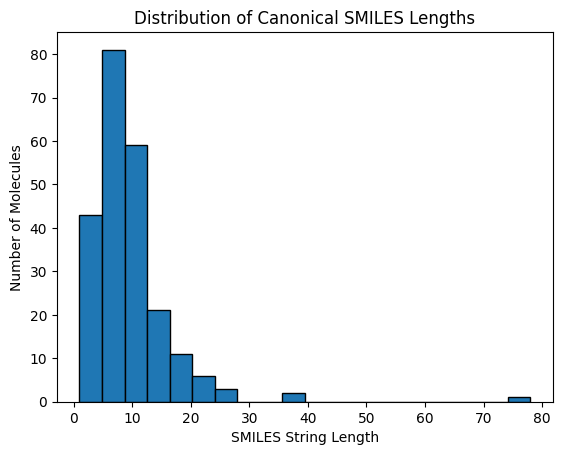

In [24]:
df_filtered["SMILES_Length"] = df_filtered["Canonical SMILES"].apply(lambda x: len(x) if x != "Not Found" else 0)

plt.hist(df_filtered["SMILES_Length"], bins=20, edgecolor="black")
plt.xlabel("SMILES String Length")
plt.ylabel("Number of Molecules")
plt.title("Distribution of Canonical SMILES Lengths")
plt.show()

In [25]:
df_long_smiles = df_filtered[df_filtered["SMILES_Length"] > 100]
print(df_long_smiles[["Name", "Canonical SMILES"]])
print(len(df_long_smiles))

Empty DataFrame
Columns: [Name, Canonical SMILES]
Index: []
0


## Feature Extraction

In [26]:
# Fix Mordred's invalid import of 'product' from numpy
!sed -i 's/from numpy import product/from itertools import product/' /usr/local/lib/python3.11/site-packages/mordred/MolecularDistanceEdge.py

In [27]:
from rdkit.Chem import rdMolDescriptors
import numpy as np
from mordred import Calculator, descriptors
from tqdm import tqdm

In [28]:
# Initialize Mordred descriptor calculator
calc = Calculator(descriptors, ignore_3D=True)
calc

In [29]:
# Function to extract molecular descriptors
def extract_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # RDKit Descriptors
        descriptors_dict = {
            "MolWt": Descriptors.MolWt(mol),  # Molecular Weight
            "LogP": Descriptors.MolLogP(mol),  # Lipophilicity
            "TPSA": Descriptors.TPSA(mol),  # Topological Polar Surface Area
            "HBD": rdMolDescriptors.CalcNumHBD(mol),  # Hydrogen Bond Donors
            "HBA": rdMolDescriptors.CalcNumHBA(mol),  # Hydrogen Bond Acceptors
            "RotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(mol),  # Flexibility
            "AromaticRings": rdMolDescriptors.CalcNumAromaticRings(mol),  # Aromaticity
            "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(mol),  # Carbon Saturation
        }

        # Mordred Descriptors
        mordred_desc = calc(mol)
        descriptors_dict.update(mordred_desc.asdict())

        return descriptors_dict

    except Exception as e:
        print(f"Error processing {smiles}: {e}")
        return None

In [30]:
# Apply function to dataframe
tqdm.pandas()  # Progress bar
df_descriptors = df_filtered["Canonical SMILES"].progress_apply(extract_descriptors)

100%|██████████| 227/227 [00:15<00:00, 14.43it/s]


In [31]:
# Convert list of dictionaries into DataFrame
df_descriptors = df_descriptors.apply(pd.Series)

In [32]:
df_descriptors.head()

,MolWt,LogP,TPSA,HBD,HBA,RotatableBonds,AromaticRings,FractionCSP3,ABC,ABCGG,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
78,32.042,-0.3915,20.23,1,1,0,0,1.0,0.0,0.0,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.0,1.0
79,32.042,-0.3915,20.23,1,1,0,0,1.0,0.0,0.0,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.0,1.0
80,32.042,-0.3915,20.23,1,1,0,0,1.0,0.0,0.0,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.0,1.0
81,32.042,-0.3915,20.23,1,1,0,0,1.0,0.0,0.0,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.0,1.0
82,32.042,-0.3915,20.23,1,1,0,0,1.0,0.0,0.0,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.0,1.0


In [ ]:
#Just downloading the Descriptors
df_descriptors.to_csv("df_with_descriptors.csv", index=False)

In [ ]:
#Downloding Data Frame with Descriptors
df_with_descriptors = pd.concat([df_filtered, df_descriptors], axis=1)
df_with_descriptors.head()
#Dropping the Descriptors column
df_with_descriptors.drop(columns=["descriptors"], inplace=True)
df_with_descriptors.to_csv("descriptors_with_reactnatnames.csv", index=False)

In [33]:
#Checking constant columns
constant_cols = df_descriptors.nunique()[df_descriptors.nunique() == 1].index
print(f"Constant columns: {list(constant_cols)}")
print(f'Number of columns: {len(constant_cols)}')
#Removing those constant columns
df_descriptors = df_descriptors.loc[:, df_descriptors.nunique() > 1]
print(f"After removing constant columns: {df_descriptors.shape}")

Constant columns: ['AromaticRings', 'nAromAtom', 'nAromBond', 'nSpiro', 'nBridgehead', 'nB', 'nP', 'nI', 'nBondsA', 'C2SP1', 'C3SP2', 'Xch-3d', 'Xch-3dv', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NtCH', 'NaaCH', 'NddC', 'NaasC', 'NaaaC', 'NsNH3', 'NssNH2', 'NaaNH', 'NsssNH', 'NaaN', 'NaasN', 'NssssN', 'NaaO', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NdsssP', 'NsssssP', 'NdS', 'NaaS', 'NddssS', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'NsssssAs', 'NsSeH', 'NdSe', 'NssSe', 'NaaSe', 'NdssSe', 'NddssSe', 'NsSnH3', 'NssSnH2', 'NsssSnH', 'NssssSn', 'NsI', 'NsPbH3', 'NssPbH2', 'NsssPbH', 'NssssPb', 'SsLi', 'SssBe', 'SssssBe', 'SssBH', 'SsssB', 'SssssB', 'StCH', 'SaaCH', 'SddC', 'SaasC', 'SaaaC', 'SsNH3', 'SssNH2', 'SaaNH', 'SsssNH', 'SaaN', 'SaasN', 'SssssN', 'SaaO', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SdsssP', 'SsssssP', 'SdS', 'SaaS', 'SddssS', 'SsGeH3', 'SssGeH2', 'Ss

In [34]:
# Get all object (non-numeric) columns
object_columns = df_descriptors.select_dtypes(include='object').columns

# Display the object column names
print(f"Number of object columns: {len(object_columns)}")
print(object_columns)

Number of object columns: 572
Index(['VR3_A', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s',
       'ATS7s', 'ATS8s',
       ...
       'MDEN-12', 'MDEN-13', 'MDEN-22', 'MDEN-23', 'MDEN-33', 'RotRatio',
       'TopoShapeIndex', 'PetitjeanIndex', 'VAdjMat', 'mZagreb1'],
      dtype='object', length=572)


In [35]:
# Check the first few rows of object columns
df_descriptors[object_columns].head()

,VR3_A,ATS0s,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS6s,ATS7s,ATS8s,...,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33,RotRatio,TopoShapeIndex,PetitjeanIndex,VAdjMat,mZagreb1
78,-1.262864,44.0,24.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.0,0.0,1.0,2.0
79,-1.262864,44.0,24.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.0,0.0,1.0,2.0
80,-1.262864,44.0,24.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.0,0.0,1.0,2.0
81,-1.262864,44.0,24.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.0,0.0,1.0,2.0
82,-1.262864,44.0,24.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.0,0.0,1.0,2.0


In [36]:
df_descriptors['VR3_A'].unique()

array([np.float64(-1.2628643221541276), np.float64(0.009034761653968602),
       np.float64(0.8573035455564525), np.float64(2.025159045890508),
       np.float64(0.8035482192409547), np.float64(1.3862943611198906),
       np.float64(1.502600249466543), np.float64(1.4620827451692444),
       np.float64(1.4620827451692449), np.float64(1.943395563362391),
       np.float64(2.4646996774701795), np.float64(2.8441178315794993),
       np.float64(3.1779074766239384), np.float64(1.9956149097586113),
       np.float64(2.006157948643833), np.float64(1.9341275586240356),
       np.float64(2.796829696545443), np.float64(3.128479202518671),
       np.float64(3.434640060465308), np.float64(3.957255841774319),
       np.float64(4.043173122334717), np.float64(5.892131444464553),
       np.float64(2.0061579486438323), np.float64(5.2742987159667845),
       np.float64(2.333234216238047), np.float64(2.579835355195132),
       np.float64(2.3977274547455556), np.float64(2.3720734636346843),
       np.float

In [37]:
#Converting the Descriptors to Numeric
df_descriptors = df_descriptors.apply(pd.to_numeric, errors='coerce')

In [38]:
df_descriptors.isnull().sum().sort_values(ascending=False).head(20)

,0
MDEN-33,227
MDEN-23,227
MDEN-22,227
MDEN-13,227
MINssPbH2,227
MINsPbH3,227
MINsssPbH,227
MINssGeH2,227
MINsssGeH,227
MINssssGe,227


In [39]:
num_all_nan = (df_descriptors.isnull().sum() == df_descriptors.shape[0]).sum()
print(f"Columns with all missing values: {num_all_nan}")

Columns with all missing values: 143


In [40]:
# Drop columns with all NaNs
df_descriptors = df_descriptors.dropna(axis=1, how='all')

In [41]:
df_descriptors.isnull().sum().sum()

np.int64(39703)

In [42]:
df_descriptors.isnull().sum().sort_values(ascending=False).head(20)

,0
MINdNH,226
MAXsF,226
MAXdssS,226
MAXdNH,226
MINsF,226
MINdssS,226
MAXddsN,225
MAXdsN,225
MINdsN,225
MINddsN,225


keeping only the columns where less than 10% Missing Data

In [43]:
#Dropping columns with too many nulls
threshold = 0.1
null_ratio = df_descriptors.isnull().mean()
dropped_columns = null_ratio[null_ratio >= threshold].index.tolist()
df_dropped = df_descriptors[dropped_columns]
print(f"Dropping {len(dropped_columns)} columns with >{threshold*100:.0f}% NaNs:")
print(dropped_columns)

df_descriptors = df_descriptors.loc[:, df_descriptors.isnull().mean() < threshold]
print(f"After dropping columns with >{threshold*100}% NaNs: {df_descriptors.shape}")
df_descriptors = df_descriptors.fillna(df_descriptors.mean())

Dropping 294 columns with >10% NaNs:
['AATS4dv', 'AATS5dv', 'AATS6dv', 'AATS7dv', 'AATS8dv', 'AATS4d', 'AATS5d', 'AATS6d', 'AATS7d', 'AATS8d', 'AATS4s', 'AATS5s', 'AATS6s', 'AATS7s', 'AATS8s', 'AATS4Z', 'AATS5Z', 'AATS6Z', 'AATS7Z', 'AATS8Z', 'AATS4m', 'AATS5m', 'AATS6m', 'AATS7m', 'AATS8m', 'AATS4v', 'AATS5v', 'AATS6v', 'AATS7v', 'AATS8v', 'AATS4se', 'AATS5se', 'AATS6se', 'AATS7se', 'AATS8se', 'AATS4pe', 'AATS5pe', 'AATS6pe', 'AATS7pe', 'AATS8pe', 'AATS4are', 'AATS5are', 'AATS6are', 'AATS7are', 'AATS8are', 'AATS4p', 'AATS5p', 'AATS6p', 'AATS7p', 'AATS8p', 'AATS4i', 'AATS5i', 'AATS6i', 'AATS7i', 'AATS8i', 'AATSC4c', 'AATSC5c', 'AATSC6c', 'AATSC7c', 'AATSC8c', 'AATSC4dv', 'AATSC5dv', 'AATSC6dv', 'AATSC7dv', 'AATSC8dv', 'AATSC4d', 'AATSC5d', 'AATSC6d', 'AATSC7d', 'AATSC8d', 'AATSC4s', 'AATSC5s', 'AATSC6s', 'AATSC7s', 'AATSC8s', 'AATSC4Z', 'AATSC5Z', 'AATSC6Z', 'AATSC7Z', 'AATSC8Z', 'AATSC4m', 'AATSC5m', 'AATSC6m', 'AATSC7m', 'AATSC8m', 'AATSC4v', 'AATSC5v', 'AATSC6v', 'AATSC7v', 'AATSC8v

In [44]:
#Dropped Columns
df_dropped

,AATS4dv,AATS5dv,AATS6dv,AATS7dv,AATS8dv,AATS4d,AATS5d,AATS6d,AATS7d,AATS8d,...,MINsOH,MINdO,MINssO,MINsF,MINsSH,MINssS,MINdssS,MINsCl,MINsBr,Kier3
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.000000,0.000000,NaN,NaN,NaN,1.000,1.000000,NaN,NaN,NaN,...,7.798611,NaN,NaN,NaN,3.670525,NaN,NaN,NaN,NaN,4.0
384,0.741667,0.494253,0.6875,0.0,0.0,1.525,1.448276,1.4375,1.0,1.0,...,8.274364,10.070883,NaN,NaN,NaN,1.604028,NaN,NaN,NaN,4.5
385,0.741667,0.494253,0.6875,0.0,0.0,1.525,1.448276,1.4375,1.0,1.0,...,8.274364,10.070883,NaN,NaN,NaN,1.604028,NaN,NaN,NaN,4.5
386,0.741667,0.494253,0.6875,0.0,0.0,1.525,1.448276,1.4375,1.0,1.0,...,8.274364,10.070883,NaN,NaN,NaN,1.604028,NaN,NaN,NaN,4.5


In [44]:
df_descriptors.isnull().sum().sum()

np.int64(0)

In [45]:
#Checking error columns
error_columns = [col for col in df_descriptors.columns
                 if df_descriptors[col].astype(str).str.contains('module|error|float|mordred',case=False).any()]
print(f"Total columns with Mordred errors: {len(error_columns)}")
print("Columns containing errors:", error_columns)
#check mordred,invalid errors as well

Total columns with Mordred errors: 0
Columns containing errors: []


In [46]:
#Dropping the error columns
df_descriptors = df_descriptors.drop(columns=error_columns)
print(f"Removed {len(error_columns)} error-containing columns and current columns: {df_descriptors.shape}")

Removed 0 error-containing columns and current columns: (227, 929)


In [47]:
# Calculate absolute correlation matrix
corr_matrix = df_descriptors.corr().abs()

# Select upper triangle (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Get all highly correlated pairs (correlation > 0.95)
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
    .query("Correlation > 0.95")
    .sort_values(by="Correlation", ascending=False)
)

#Decide which columns to drop (keep Feature_1, drop Feature_2)
to_drop = high_corr_pairs["Feature_2"].unique().tolist()

#Log the dropping process
print(f"Removed {len(to_drop)} highly correlated features:\n")
for col in to_drop:
    correlated_with = high_corr_pairs[high_corr_pairs["Feature_2"] == col]
    for _, row in correlated_with.iterrows():
        print(f"'{row['Feature_2']}' is highly correlated with '{row['Feature_1']}' (r = {row['Correlation']:.4f})")

#Drop the correlated columns
df_descriptors = df_descriptors.drop(columns=to_drop)

# Save correlation report
high_corr_pairs.to_csv("highly_correlated_pairs.csv", index=False)

# Final shape
print(f"\n Final descriptor shape after dropping: {df_descriptors.shape}")

Streaming output truncated to the last 5000 lines.
'ATS7are' is highly correlated with 'ATS8pe' (r = 0.9751)
'ATS7are' is highly correlated with 'ATS7Z' (r = 0.9737)
'ATS7are' is highly correlated with 'ATS7s' (r = 0.9713)
'ATS7are' is highly correlated with 'ATS6Z' (r = 0.9706)
'ATS7are' is highly correlated with 'ATS8d' (r = 0.9653)
'ATS7are' is highly correlated with 'ATS6m' (r = 0.9647)
'ATS7are' is highly correlated with 'ATS7m' (r = 0.9622)
'ATS7are' is highly correlated with 'ATS8v' (r = 0.9604)
'MW' is highly correlated with 'MolWt' (r = 1.0000)
'MW' is highly correlated with 'Sm' (r = 1.0000)
'MW' is highly correlated with 'SZ' (r = 0.9967)
'MW' is highly correlated with 'ATS1m' (r = 0.9841)
'MW' is highly correlated with 'ATS1Z' (r = 0.9829)
'MW' is highly correlated with 'ETA_alpha' (r = 0.9815)
'MW' is highly correlated with 'ZMIC0' (r = 0.9814)
'MW' is highly correlated with 'LabuteASA' (r = 0.9790)
'MW' is highly correlated with 'ATS2Z' (r = 0.9683)
'MW' is highly correla

In [48]:
print(f"Removed {len(to_drop)} highly correlated features and shape is {df_descriptors.shape}")

Removed 519 highly correlated features and shape is (227, 410)


In [49]:
#Checking for Null Values
df_descriptors.isnull().values.any()

np.False_

In [50]:
df_descriptors.head()

,MolWt,LogP,TPSA,HBD,HBA,RotatableBonds,FractionCSP3,nAcid,nBase,SpMax_A,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGT10,TopoShapeIndex,mZagreb1
78,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
79,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
81,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
82,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [51]:
#Performing PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale the data (important before PCA!)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_descriptors)

# PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(scaled_data)

print(f"Original shape: {scaled_data.shape}")
print(f"PCA-transformed shape: {X_pca.shape}")

Original shape: (227, 410)
PCA-transformed shape: (227, 42)


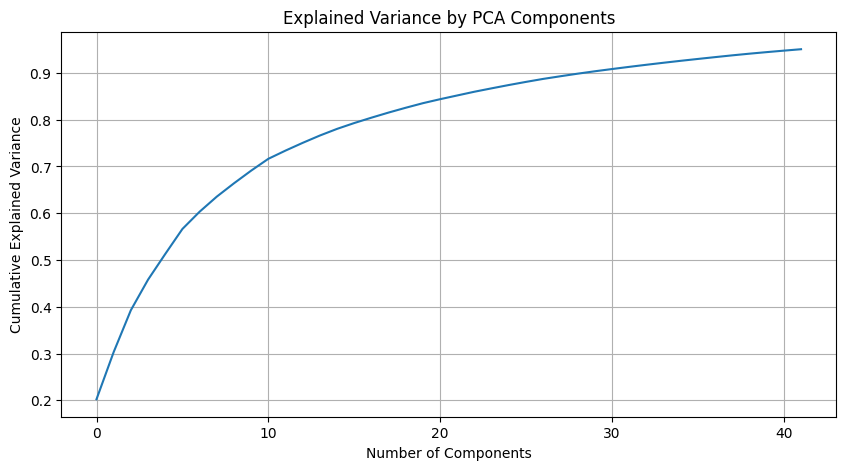

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [53]:
df_descriptors.head()

,MolWt,LogP,TPSA,HBD,HBA,RotatableBonds,FractionCSP3,nAcid,nBase,SpMax_A,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGT10,TopoShapeIndex,mZagreb1
78,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
79,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
81,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
82,32.042,-0.3915,20.23,1,1,0,1.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


## Feature Extraction MACCS FingerPrints and MTE [Not Performing]

In [52]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 78 to 387
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              227 non-null    object 
 1   Canonical SMILES  227 non-null    object 
 2   pH                227 non-null    object 
 3   k                 227 non-null    float64
 4   Rxn Type          227 non-null    object 
 5   SMILES_Length     227 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 12.4+ KB


In [ ]:
# Generate RDKit molecules from SMILES
df["Mol"] = df["Canonical SMILES"].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

[01:17:50] WARNING: not removing hydrogen atom without neighbors
[01:17:50] WARNING: not removing hydrogen atom without neighbors
[01:17:50] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC(N)OC2CO)O2'
[01:17:50] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC(N)OC2CO)O3'
[01:17:50] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC(N)OC2CO)O4'


In [ ]:
df.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,Mol
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,<rdkit.Chem.rdchem.Mol object at 0x7ba67a7358c0>
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735690>
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735850>
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735700>
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735770>


In [ ]:
# Compute MACCS Fingerprints
def get_maccs_fingerprint(mol):
    if mol:
        return list(MACCSkeys.GenMACCSKeys(mol))  # Convert to list
    else:
        return [np.nan] * 167  # MACCS has 167 bits

In [ ]:
df["MACCS"] = df["Mol"].apply(get_maccs_fingerprint)

In [ ]:
df.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,Mol,MACCS
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,<rdkit.Chem.rdchem.Mol object at 0x7ba67a7358c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735690>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735850>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,<rdkit.Chem.rdchem.Mol object at 0x7ba67a735770>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df.shape

(559, 8)

In [ ]:
# Convert list of fingerprints to separate columns
maccs_df = df["MACCS"].apply(pd.Series)

# Rename columns for clarity
maccs_df.columns = [f"MACCS_{i}" for i in range(167)]

# Merge with original data
df_final = pd.concat([df.drop(columns=["Mol", "MACCS"]), maccs_df], axis=1)

In [ ]:
df_final.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_final.isnull().sum()

,0
Name,0
Canonical SMILES,0
pH,0
k,0
Rxn Type,0
...,...
MACCS_162,3
MACCS_163,3
MACCS_164,3
MACCS_165,3


In [ ]:
df_final[df_final["MACCS_0"].isnull()]

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
529,DNA,NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC...,12.4,6.000000e+08,Nucleic Acid Derivatives,57,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,DNA,NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC...,9,1.000000e+13,Nucleic Acid Derivatives,57,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,DNA,NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC...,7.5,1.300000e+13,Nucleic Acid Derivatives,57,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop rows where any MACCS descriptor is NaN
df_final_cleaned = df_final.dropna()

# Reset the index after dropping rows
df_final_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
df_final_cleaned.isnull().sum().sum()

np.int64(0)

In [ ]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Columns: 173 entries, Name to MACCS_166
dtypes: float64(168), int64(1), object(4)
memory usage: 751.6+ KB


In [ ]:
# Convert all MACCS fingerprint columns to integers (0 or 1)
maccs_cols = [col for col in df_final_cleaned.columns if "MACCS_" in col]
df_final_cleaned[maccs_cols] = df_final_cleaned[maccs_cols].astype(int)

# Check the first few rows
df_final_cleaned.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
#Molecular Transfer Embeddings
# Load pre-trained ChemBERTa model (can use other molecular transformer models too)
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
# Function to get embeddings from SMILES
def get_molecular_embedding(smiles):
    if smiles is None or smiles == "":
        return None
    try:
        tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            output = model(**tokens)
        return output.last_hidden_state.mean(dim=1).squeeze().numpy()  # Get mean-pooled embedding
    except:
        return None  # Handle errors


In [ ]:
# Apply to dataset
df_final_cleaned["Transformer_Embedding"] = df_final_cleaned["Canonical SMILES"].apply(get_molecular_embedding)

In [ ]:
df_final_cleaned.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,Transformer_Embedding
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,0,0,0,0,...,1,0,1,1,1,1,1,1,0,"[0.7942484, 1.4899749, -0.03859988, -0.0871674..."
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,0,0,0,0,...,0,0,1,0,1,1,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,0,0,0,0,...,0,0,1,0,1,1,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,0,0,0,0,...,1,0,0,1,0,0,1,0,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,0,0,0,0,...,1,0,0,1,0,0,1,0,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."


In [ ]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Columns: 174 entries, Name to Transformer_Embedding
dtypes: float64(1), int64(168), object(5)
memory usage: 755.9+ KB


In [ ]:
# Convert Transformer Embeddings column into separate features
embeddings_matrix = np.vstack(df_final_cleaned["Transformer_Embedding"].dropna().values)
embedding_df = pd.DataFrame(embeddings_matrix, columns=[f"Embedding_{i}" for i in range(embeddings_matrix.shape[1])])

# Merge with original dataset
df_final_embeddings = pd.concat([df_final_cleaned.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)

# Drop original Transformer Embedding column
df_final_embeddings.drop(columns=["Transformer_Embedding"], inplace=True)

In [ ]:
df_final_embeddings.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,0,0,0,0,...,-0.101718,0.222749,-0.814970,-0.556503,-0.263230,0.269693,-0.701040,0.058131,0.024336,0.666652
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795


In [ ]:
df_final_embeddings.isnull().sum().sum()

np.int64(0)

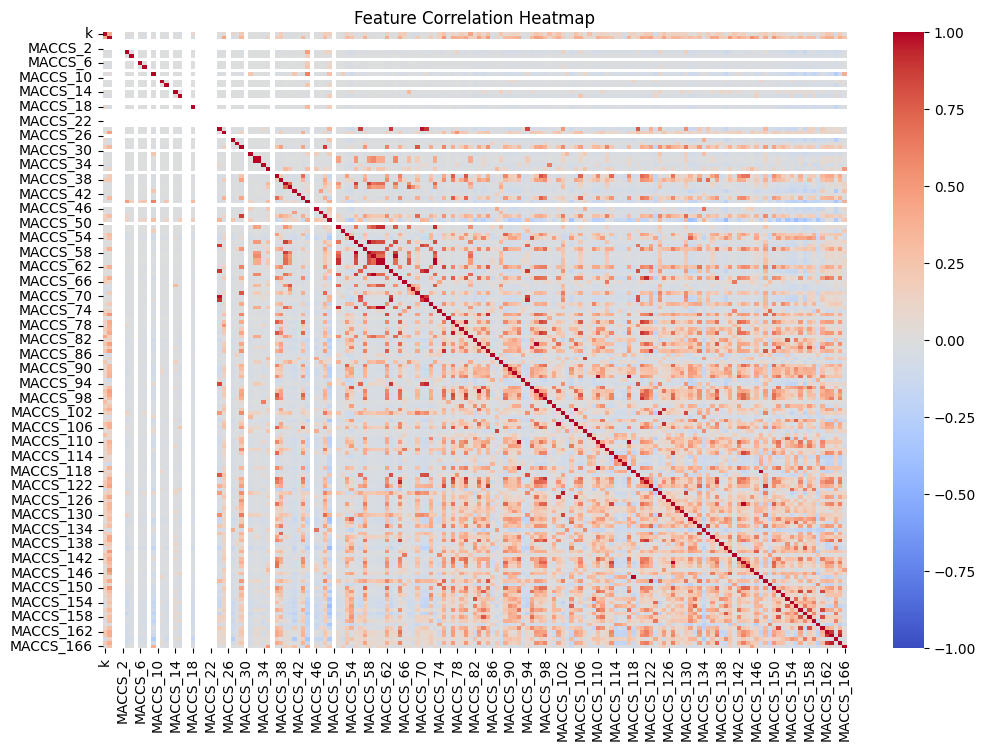

In [ ]:
# Compute correlation matrix
numerical_df_MACCS = df_final_cleaned.select_dtypes(include=["float64","int64"])
correlation_matrix = numerical_df_MACCS.corr()

# Plot heatmap of top 50 features (for visualization clarity)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmax=1.0, vmin=-1.0, center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Set threshold for high correlation
corr_threshold = 0.85

# Identify highly correlated feature pairs
correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert correlated pairs into a DataFrame for better visualization
correlated_df = pd.DataFrame(correlated_pairs, columns=["Feature_1", "Feature_2", "Correlation_Value"])

# Sort by correlation value (highest first)
correlated_df = correlated_df.sort_values(by="Correlation_Value", ascending=False)


In [ ]:
len(correlated_df)

51

In [ ]:
# Identify unique features to remove
features_to_remove = set(correlated_df["Feature_1"])  # Keep only one from each pair
len(features_to_remove)

# Drop correlated features from dataset
df_reduced = df_final_cleaned.drop(columns=features_to_remove)

print(f"Removed {len(features_to_remove)} correlated features.")


Removed 34 correlated features.


In [ ]:
embedding_df.head()
embedding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Columns: 768 entries, Embedding_0 to Embedding_767
dtypes: float32(768)
memory usage: 1.6 MB


In [ ]:
# Compute correlation matrix
correlation_matrix_em = embedding_df.corr()

# Set threshold for high correlation
corr_threshold = 0.85

# Identify highly correlated feature pairs
embedding_correlated_pairs = []

for i in range(len(correlation_matrix_em.columns)):
    for j in range(i):
        if abs(correlation_matrix_em.iloc[i, j]) > corr_threshold:
            embedding_correlated_pairs.append((correlation_matrix_em.columns[i],
                                               correlation_matrix_em.columns[j],
                                               correlation_matrix_em.iloc[i, j]))

# Convert to DataFrame for better visualization
embedding_correlated_df = pd.DataFrame(embedding_correlated_pairs,
                                       columns=["Feature_1", "Feature_2", "Correlation_Value"])

# Sort by correlation value (highest first)
embedding_correlated_df = embedding_correlated_df.sort_values(by="Correlation_Value", ascending=False)

In [ ]:
# Identify unique features to remove (keep only one from each pair)
embedding_features_to_remove = set(embedding_correlated_df["Feature_1"])

# Drop correlated features from embeddings
embeddings_df_reduced = embedding_df.drop(columns=embedding_features_to_remove)

print(f"Removed {len(embedding_features_to_remove)} correlated embedding features.")

Removed 85 correlated embedding features.


In [ ]:
embeddings_df_reduced.head()
df_reduced.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_155,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_164,MACCS_166,Transformer_Embedding
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,0,0,0,0,...,0,0,1,0,1,1,1,1,0,"[0.7942484, 1.4899749, -0.03859988, -0.0871674..."
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,0,0,0,0,...,0,0,0,0,1,0,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,0,0,0,0,...,0,0,0,0,1,0,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,0,0,0,0,...,0,0,1,0,0,1,0,1,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,0,0,0,0,...,0,0,1,0,0,1,0,1,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."


In [ ]:
# Merge with original dataset
df_final = pd.concat([df_reduced.reset_index(drop=True), embeddings_df_reduced.reset_index(drop=True)], axis=1)

# Drop original Transformer Embedding column
df_final.drop(columns=["Transformer_Embedding"], inplace=True)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Columns: 822 entries, Name to Embedding_767
dtypes: float32(683), float64(1), int64(134), object(4)
memory usage: 2.0+ MB


In [ ]:
df_final.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15,0,0,0,0,...,-0.101718,0.222749,-0.814970,-0.556503,-0.263230,0.269693,-0.701040,0.058131,0.024336,0.666652
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795


In [ ]:
# Reset index to ensure alignment, then concatenate side-by-side
df_final_fe = pd.concat([df_final.reset_index(drop=True),
                             df_feature_imp_cols_descriptors.reset_index(drop=True)],
                             axis=1)

print(df_final_fe.shape)
df_final_fe.head()


(559, 851)


,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,AATSC0dv,ATSC3i,BIC2,ETA_epsilon_1,BIC0,RNCG,AETA_eta_RL,AATSC0pe,PEOE_VSA1,BCUTc-1h
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition,15.0,0.0,0.0,0.0,0.0,...,3.639889,3.975808,0.693343,0.571930,0.327889,0.379017,0.478769,0.103674,5.316789,0.364071
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition,14.0,0.0,0.0,0.0,0.0,...,3.591696,-3.932555,0.647755,0.556863,0.287760,0.504654,0.478281,0.091618,0.000000,0.352404
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition,14.0,0.0,0.0,0.0,0.0,...,3.591696,-3.932555,0.647755,0.556863,0.287760,0.504654,0.478281,0.091618,0.000000,0.352404
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition,9.0,0.0,0.0,0.0,0.0,...,4.160000,-5.146862,0.844627,0.616667,0.487212,0.498439,0.454011,0.163101,5.733667,0.385966
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition,9.0,0.0,0.0,0.0,0.0,...,4.160000,-5.146862,0.844627,0.616667,0.487212,0.498439,0.454011,0.163101,5.733667,0.385966


## Feature Engineering

In [54]:
X_pca

array([[-12.97296728,  -1.36823462,  -9.44163532, ...,   0.25756456,
         -0.04306807,  -1.19720932],
       [-12.97296728,  -1.36823462,  -9.44163532, ...,   0.25756456,
         -0.04306807,  -1.19720932],
       [-12.97296728,  -1.36823462,  -9.44163532, ...,   0.25756456,
         -0.04306807,  -1.19720932],
       ...,
       [  9.2452657 ,  -0.74507242,   0.5214976 , ...,  -0.37043666,
         -0.93727431,  -0.08790856],
       [  9.2452657 ,  -0.74507242,   0.5214976 , ...,  -0.37043666,
         -0.93727431,  -0.08790856],
       [  0.18431457,  11.16603915,   6.36844318, ...,   1.64122673,
         -0.68105167,  -0.32329498]])

In [55]:
#PCA Dataframe
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

In [56]:
#No PCA Dataframe
no_pca_df = pd.DataFrame(scaled_data, columns=df_descriptors.columns)

In [57]:
df_filtered.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2


In [59]:
# Merging with original Dataset PCA
meta_cols = ['Name', 'Canonical SMILES', 'pH', 'k', 'Rxn Type', 'SMILES_Length']

df_final = pd.concat([df_filtered[meta_cols].reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

In [60]:
# Merging with original Dataset No PCA
meta_cols = ['Name', 'Canonical SMILES', 'pH', 'k', 'Rxn Type', 'SMILES_Length']

df_final_no_pca = pd.concat([df_filtered[meta_cols].reset_index(drop=True), no_pca_df.reset_index(drop=True)], axis=1)

In [61]:
# Apply logarithm transformation to k PCA
df_final["log_k"] = np.log10(df_final["k"])

# Drop the original k column
df_final.drop(columns=["k"], inplace=True)

In [62]:
# Apply logarithm transformation to k No PCA
df_final_no_pca["log_k"] = np.log10(df_final_no_pca["k"])

# Drop the original k column
df_final_no_pca.drop(columns=["k"], inplace=True)

In [63]:
df_final.head()

,Name,Canonical SMILES,pH,Rxn Type,SMILES_Length,PC1,PC2,PC3,PC4,PC5,...,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,log_k
0,methanol,CO,2,Hydrogen Abstraction,2,-12.972967,-1.368235,-9.441635,0.081685,5.223389,...,0.63645,0.613648,-0.581041,0.352343,-0.110819,0.713943,0.257565,-0.043068,-1.197209,9.873902
1,methanol,CO,6,Hydrogen Abstraction,2,-12.972967,-1.368235,-9.441635,0.081685,5.223389,...,0.63645,0.613648,-0.581041,0.352343,-0.110819,0.713943,0.257565,-0.043068,-1.197209,8.934498
2,methanol,CO,7,Hydrogen Abstraction,2,-12.972967,-1.368235,-9.441635,0.081685,5.223389,...,0.63645,0.613648,-0.581041,0.352343,-0.110819,0.713943,0.257565,-0.043068,-1.197209,9.888741
3,methanol,CO,9,Hydrogen Abstraction,2,-12.972967,-1.368235,-9.441635,0.081685,5.223389,...,0.63645,0.613648,-0.581041,0.352343,-0.110819,0.713943,0.257565,-0.043068,-1.197209,9.017033
4,methanol,CO,10.5,Hydrogen Abstraction,2,-12.972967,-1.368235,-9.441635,0.081685,5.223389,...,0.63645,0.613648,-0.581041,0.352343,-0.110819,0.713943,0.257565,-0.043068,-1.197209,8.977724


In [64]:
df_final_no_pca.head()

,Name,Canonical SMILES,pH,Rxn Type,SMILES_Length,MolWt,LogP,TPSA,HBD,HBA,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGT10,TopoShapeIndex,mZagreb1,log_k
0,methanol,CO,2,Hydrogen Abstraction,2,-1.31273,-0.501696,-0.626088,-0.207072,-0.561735,...,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-2.114723,-2.425379,-1.154895,9.873902
1,methanol,CO,6,Hydrogen Abstraction,2,-1.31273,-0.501696,-0.626088,-0.207072,-0.561735,...,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-2.114723,-2.425379,-1.154895,8.934498
2,methanol,CO,7,Hydrogen Abstraction,2,-1.31273,-0.501696,-0.626088,-0.207072,-0.561735,...,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-2.114723,-2.425379,-1.154895,9.888741
3,methanol,CO,9,Hydrogen Abstraction,2,-1.31273,-0.501696,-0.626088,-0.207072,-0.561735,...,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-2.114723,-2.425379,-1.154895,9.017033
4,methanol,CO,10.5,Hydrogen Abstraction,2,-1.31273,-0.501696,-0.626088,-0.207072,-0.561735,...,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-2.114723,-2.425379,-1.154895,8.977724


In [65]:
#Ensuring proper Data Types PCA
df_final["pH"] = df_final["pH"].astype(float)

In [66]:
#Ensuring proper Data Types No PCA
df_final_no_pca["pH"] = df_final_no_pca["pH"].astype(float)

In [67]:
print(df_final.dtypes)

Name                 object
Canonical SMILES     object
pH                  float64
Rxn Type             object
SMILES_Length         int64
PC1                 float64
PC2                 float64
PC3                 float64
PC4                 float64
PC5                 float64
PC6                 float64
PC7                 float64
PC8                 float64
PC9                 float64
PC10                float64
PC11                float64
PC12                float64
PC13                float64
PC14                float64
PC15                float64
PC16                float64
PC17                float64
PC18                float64
PC19                float64
PC20                float64
PC21                float64
PC22                float64
PC23                float64
PC24                float64
PC25                float64
PC26                float64
PC27                float64
PC28                float64
PC29                float64
PC30                float64
PC31                

In [68]:
df_final.isnull().sum().sort_values(ascending=False).head(10)
# df_final = df_final.dropna()

,0
Name,0
Canonical SMILES,0
pH,0
Rxn Type,0
SMILES_Length,0
PC1,0
PC2,0
PC3,0
PC4,0
PC5,0


In [69]:
#Positive Correlation PCA
df_final.select_dtypes(include=[np.number]).corr()['log_k'].sort_values(ascending=False).head(10)

,log_k
log_k,1.000000
PC22,0.231935
PC4,0.198307
PC21,0.189538
PC18,0.165622
PC12,0.156493
PC25,0.107861
PC36,0.098881
PC16,0.083154
PC40,0.074317


In [169]:
#Checking for Negative Corealtion PCA
df_final.select_dtypes(include=[np.number]).corr()['log_k'].sort_values().head(10)

,log_k
PC2,-0.542372
PC27,-0.240967
PC5,-0.207753
PC19,-0.159588
PC15,-0.144290
PC3,-0.143180
PC29,-0.133740
PC8,-0.120943
PC26,-0.113438
PC6,-0.110952


In [170]:
#Positive Coorealtion No PCA
df_final_no_pca.select_dtypes(include=[np.number]).corr()['log_k'].sort_values(ascending=False).head(10)

,log_k
log_k,1.000000
AATSC3dv,0.544455
MATS3dv,0.522942
AETA_eta_L,0.456379
MATS3Z,0.447681
MATS3s,0.447512
AATSC3s,0.427982
nH,0.401043
GATS2Z,0.394682
ATSC0p,0.391267


In [171]:
#Checking for Negative Corealtion no PCA
df_final_no_pca.select_dtypes(include=[np.number]).corr()['log_k'].sort_values().head(10)

,log_k
AATS3se,-0.590306
AETA_beta_ns,-0.558030
AETA_beta,-0.521865
AETA_eta_FL,-0.521248
AATS3s,-0.513637
AATS0dv,-0.473270
AETA_dBeta,-0.462615
AATS0se,-0.439007
AATS0s,-0.434041
AATSC0dv,-0.432835


## Model Training

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error

In [71]:
# Define input features (excluding non-numeric columns) PCA
X = df_final.drop(columns=["Name", "Canonical SMILES", "log_k","Rxn Type"])  # Features
y = df_final["log_k"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train.head()

,pH,SMILES_Length,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
60,7.0,8,0.830114,-0.280127,-7.616851,-3.083161,-0.671217,-5.435759,-0.457956,0.397097,...,-0.221808,0.745798,0.149338,0.281687,-0.933590,0.126741,-0.153265,0.188941,-0.465837,0.510403
164,9.0,5,-4.666532,-4.041947,-4.954048,-2.238591,3.822684,-0.233275,2.993396,0.327589,...,0.206441,0.776970,0.816456,0.713907,-0.322217,-0.384647,-0.945780,0.603446,0.281207,0.736945
68,9.0,13,8.047676,-5.063884,-1.866889,-2.910331,2.833458,-11.440118,1.112166,-0.395828,...,-1.427471,0.297250,1.355539,0.598338,-1.992864,0.214531,1.930520,-1.331351,-1.383946,1.278412
183,9.0,13,-3.658405,11.794741,5.738010,-2.324527,9.162635,8.117421,-1.145568,4.326027,...,-1.203426,1.686548,-1.357166,0.351220,-0.942942,-0.798625,-0.244184,-0.301869,-0.722219,-0.052550
216,10.0,6,-15.572370,1.775980,4.656342,39.716722,8.340380,-2.004383,8.073719,-3.667849,...,0.435113,0.018650,-0.389479,-1.511005,0.260362,0.453782,-1.465848,-0.416948,0.364127,0.628345


In [80]:
X_test.head()

,pH,SMILES_Length,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
9,7.0,3,-9.513411,-1.060357,-3.885623,-1.297943,-0.349949,0.452620,-4.133579,0.120209,...,0.403717,-0.522771,-0.406191,0.208801,0.036507,0.193017,-0.250866,0.937813,0.483914,-0.535292
143,6.5,12,1.458949,-1.790899,7.486516,-2.010792,3.522346,4.340518,1.995300,-0.058363,...,0.838554,-0.445011,-0.894703,0.152242,-0.789573,-0.145380,-0.163170,0.593375,-1.158371,-0.322887
15,9.0,5,-5.686267,1.423554,-4.985265,1.229888,-4.004122,-0.592268,0.614654,5.277506,...,1.689119,0.539733,0.964547,-0.407623,3.237444,-1.249147,0.044065,-0.009542,-0.006705,1.277273
124,2.0,19,14.254459,-6.096120,-0.397255,2.222422,-6.741908,11.611779,-3.495955,-4.666720,...,-1.904574,-2.373546,5.623955,-0.960494,0.411608,2.724414,0.119766,-1.472858,-1.515660,0.132869
153,7.0,5,-6.329060,-7.794503,-0.757023,-2.825504,2.132945,3.500806,3.389487,1.247343,...,1.901370,-0.463727,0.586963,0.761495,0.316726,0.630830,-0.594311,0.030000,-1.205099,-0.878599


In [73]:
y_train.head()

,log_k
60,9.243038
164,9.113943
68,9.505150
183,8.491362
216,9.740363


In [74]:
# Define input features (excluding non-numeric columns) NO PCA
X_no_pca = df_final_no_pca.drop(columns=["Name", "Canonical SMILES", "log_k","Rxn Type"])  # Features
y_no_pca = df_final_no_pca["log_k"]

# Train-test split (80% train, 20% test)
X_train_no_pca, X_test_no_pca, y_train_no_pca, y_test_no_pca = train_test_split(X_no_pca, y_no_pca, test_size=0.2, random_state=42)

In [75]:
X_train_no_pca.head()

,pH,SMILES_Length,MolWt,LogP,TPSA,HBD,HBA,RotatableBonds,FractionCSP3,nAcid,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGT10,TopoShapeIndex,mZagreb1
60,7.0,8,-0.014185,-1.775047,0.729864,1.471694,1.012510,0.257479,0.811903,-0.599571,...,0.060613,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,0.283905,0.850241,-4.261144e-02
164,9.0,5,-0.360142,-0.485138,-0.316759,-0.207072,0.225388,0.257479,0.811903,-0.599571,...,0.885602,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-0.764225,0.850241,-6.371076e-01
68,9.0,13,0.938403,-2.163955,1.407840,2.311077,1.799633,1.310591,0.811903,-0.599571,...,0.885602,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,0.832470,0.850241,9.594023e-01
183,9.0,13,-0.685686,-0.218020,0.141704,-1.046456,0.225388,-0.795633,0.811903,-0.599571,...,-0.764376,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,0.466760,0.850241,-3.878028e-01
216,10.0,6,-0.254597,-1.025061,-1.304063,-1.046456,-1.348858,-0.795633,-2.751347,-0.599571,...,-0.764376,-0.500947,-0.359963,-0.260693,-0.235604,-0.188901,-0.134305,-2.114723,0.000000,3.065915e-16


In [76]:
# Initialize models
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.1)  # Alpha controls regularization strength
ridge_model = Ridge(alpha=1.0)

In [81]:
# Train models PCA
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

Ridge()

In [82]:
# Make predictions PCA
y_pred_linear = linear_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

In [83]:
# Train models No PCA
linear_model.fit(X_train_no_pca, y_train_no_pca)
lasso_model.fit(X_train_no_pca, y_train_no_pca)
ridge_model.fit(X_train_no_pca, y_train_no_pca)

Ridge()

In [84]:
# Make predictions No PCA
y_pred_linear_no_pca = linear_model.predict(X_test_no_pca)
y_pred_lasso_no_pca = lasso_model.predict(X_test_no_pca)
y_pred_ridge_no_pca = ridge_model.predict(X_test_no_pca)

In [85]:
# Evaluate models
results = {
    "Model": ["Linear Regression", "Lasso Regression", "Ridge Regression"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_linear),
        mean_absolute_error(y_test, y_pred_lasso),
        mean_absolute_error(y_test, y_pred_ridge),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_linear)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge),
    ],
}

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [86]:
display(results_df)

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.323142,0.429256,0.728798
1,Lasso Regression,0.359597,0.494492,0.640103
2,Ridge Regression,0.322393,0.428326,0.729971


In [87]:
# Evaluate models No PCA
results_no_pca= {
    "Model": ["Linear Regression", "Lasso Regression", "Ridge Regression"],
    "MAE": [
        mean_absolute_error(y_test_no_pca, y_pred_linear_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_lasso_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_ridge_no_pca),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_linear_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_lasso_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_ridge_no_pca)),
    ],
    "R² Score": [
        r2_score(y_test_no_pca, y_pred_linear_no_pca),
        r2_score(y_test_no_pca, y_pred_lasso_no_pca),
        r2_score(y_test_no_pca, y_pred_ridge_no_pca),
    ],
}

# Convert results to a DataFrame
results_no_pca_df = pd.DataFrame(results_no_pca)

In [88]:
display(results_no_pca_df)

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.356712,0.520591,0.601109
1,Lasso Regression,0.417592,0.540958,0.569288
2,Ridge Regression,0.224250,0.336626,0.833215


In [104]:
# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [105]:
# Train models PCA
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [106]:
# Make predictions PCA
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [100]:
# Initialize models No PCA
rf_model_no_pca = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model_no_pca = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [101]:
# Train models No PCA
rf_model_no_pca.fit(X_train_no_pca, y_train_no_pca)
xgb_model_no_pca.fit(X_train_no_pca, y_train_no_pca)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [102]:
# Make predictions No PCA
y_pred_rf_no_pca = rf_model_no_pca.predict(X_test_no_pca)
y_pred_xgb_no_pca = xgb_model_no_pca.predict(X_test_no_pca)

In [94]:
# Evaluate models PCA
results_tree = {
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
    ],
}

In [103]:
results_tree

,Model,MAE,RMSE,R² Score
0,Random Forest,0.279575,0.390938,0.775055
1,XGBoost,0.268630,0.425377,0.733678


In [96]:
# Convert results to a DataFrame PCA
results_tree = pd.DataFrame(results_tree)
display(results_tree)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.279575,0.390938,0.775055
1,XGBoost,0.268630,0.425377,0.733678


In [97]:
# Evaluate models PCA
results_tree_no_pca = {
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test_no_pca, y_pred_rf_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_xgb_no_pca),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_rf_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_xgb_no_pca)),
    ],
    "R² Score": [
        r2_score(y_test_no_pca, y_pred_rf_no_pca),
        r2_score(y_test_no_pca, y_pred_xgb_no_pca),
    ],
}

In [98]:
# Convert results to a DataFrame No PCA
results_tree_no_pca = pd.DataFrame(results_tree_no_pca)
display(results_tree_no_pca)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.243246,0.353423,0.816156
1,XGBoost,0.238278,0.372720,0.795532


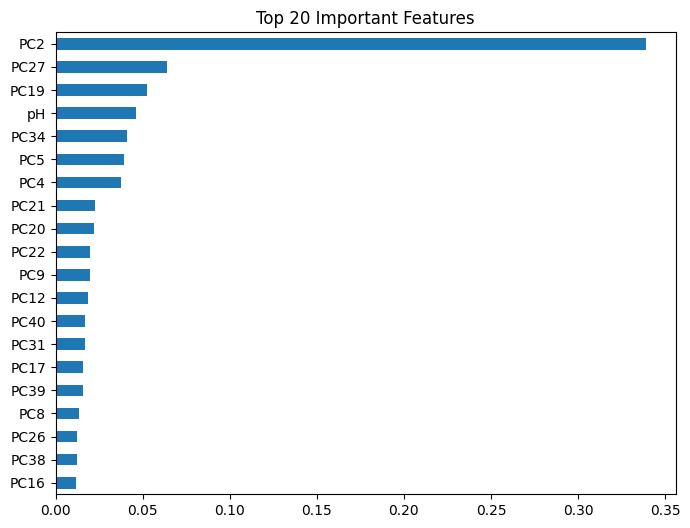

In [107]:
#PCA
importances = rf_model.feature_importances_
feat_names = X.columns
feat_series = pd.Series(importances, index=feat_names).sort_values(ascending=False)

feat_series.head(20).plot(kind='barh', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features")
plt.show()

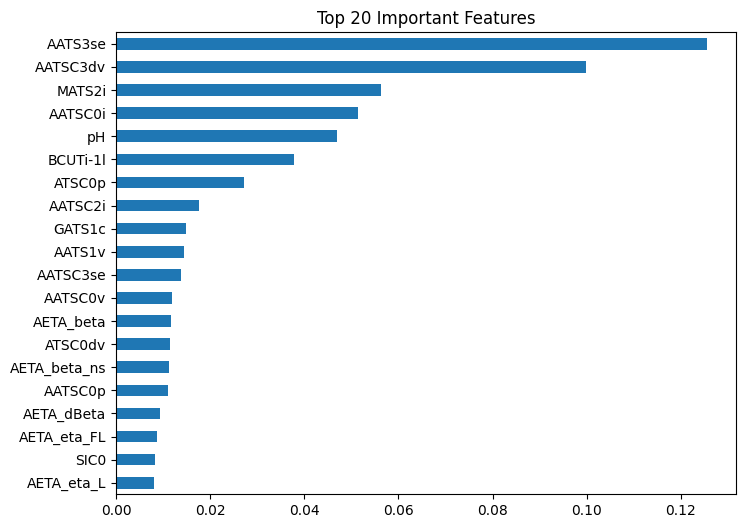

In [109]:
#No PCA
importances_no_pca = rf_model_no_pca.feature_importances_
feat_names_no_pca = X_no_pca.columns
feat_series_no_pca = pd.Series(importances_no_pca, index=feat_names_no_pca).sort_values(ascending=False)

feat_series_no_pca.head(20).plot(kind='barh', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features")
plt.show()

In [110]:
# Select top 30 features PCA
top_features = feat_series.head(30).index.tolist()

print("Top 30 Features:", top_features)

Top 30 Features: ['PC2', 'PC27', 'PC19', 'pH', 'PC34', 'PC5', 'PC4', 'PC21', 'PC20', 'PC22', 'PC9', 'PC12', 'PC40', 'PC31', 'PC17', 'PC39', 'PC8', 'PC26', 'PC38', 'PC16', 'PC25', 'PC36', 'PC15', 'PC29', 'PC30', 'PC37', 'PC3', 'PC42', 'PC1', 'PC6']


In [111]:
# Select top 30 features No PCA
top_features_no_pca = feat_series_no_pca.head(30).index.tolist()

print("Top 30 Features:", top_features_no_pca)

Top 30 Features: ['AATS3se', 'AATSC3dv', 'MATS2i', 'AATSC0i', 'pH', 'BCUTi-1l', 'ATSC0p', 'AATSC2i', 'GATS1c', 'AATS1v', 'AATSC3se', 'AATSC0v', 'AETA_beta', 'ATSC0dv', 'AETA_beta_ns', 'AATSC0p', 'AETA_dBeta', 'AETA_eta_FL', 'SIC0', 'AETA_eta_L', 'AATSC3Z', 'AATS0v', 'AATSC3v', 'AATS3s', 'ATSC1Z', 'MATS3dv', 'GATS3dv', 'IC2', 'BCUTc-1l', 'RPCG']


In [112]:
# Convert to a DataFrame
features_df = pd.DataFrame(top_features_no_pca, columns=['Top_Features'])

# Save to CSV
features_df.to_csv('top_30_features_no_pca.csv', index=False)

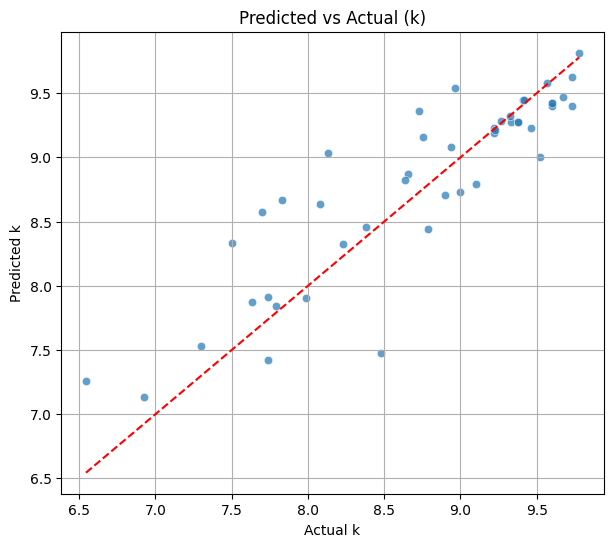

In [113]:
# y_test and y_pred should be our true and predicted values PCA
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)

# Optional: Line y = x for perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')

plt.xlabel("Actual k")
plt.ylabel("Predicted k")
plt.title("Predicted vs Actual (k)")
plt.grid(True)
plt.show()

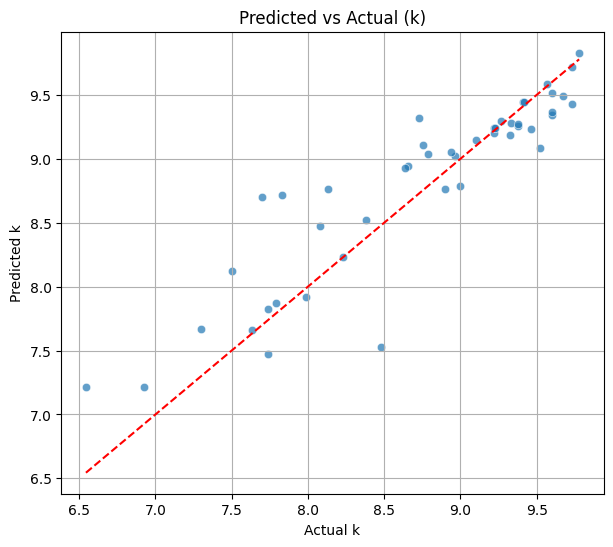

In [114]:
# y_test and y_pred should be our true and predicted values No PCA
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_no_pca, y=y_pred_rf_no_pca, alpha=0.7)

# Optional: Line y = x for perfect prediction
plt.plot([y_test_no_pca.min(), y_test_no_pca.max()], [y_test_no_pca.min(), y_test_no_pca.max()], '--r')

plt.xlabel("Actual k")
plt.ylabel("Predicted k")
plt.title("Predicted vs Actual (k)")
plt.grid(True)
plt.show()

In [116]:
# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual_k': y_test_no_pca,
    'Predicted_k': y_pred_rf_no_pca
})

# Display the DataFrame
comparison_df.head()

,Actual_k,Predicted_k
9,9.222716,9.198267
143,8.653213,8.940001
15,8.963788,9.023700
124,9.602060,9.516602
153,9.459392,9.236608


In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [118]:
#PCA
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

In [119]:
# Evaluate models PCA
results_tree = {
    "Model": ["Random Forest", "XGBoost","Hyperparameter Tuned RF"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_best)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_pred_best)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_best),
    ],
}

In [120]:
#PCA
results_tree

{'Model': ['Random Forest', 'XGBoost', 'Hyperparameter Tuned RF'],
 'MAE': [0.27957504429165053, 0.2686302492300815, 0.2638544715031299],
 'RMSE': [np.float64(0.39093756153132353),
  np.float64(0.42537656852665284),
  np.float64(0.37895240181628853)],
 'R² Score': [0.7750554690689302, 0.7336775568592969, 0.7886365120300073]}

In [121]:
# Convert results to a DataFrame PCA
results_tree = pd.DataFrame(results_tree)
display(results_tree)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.279575,0.390938,0.775055
1,XGBoost,0.268630,0.425377,0.733678
2,Hyperparameter Tuned RF,0.263854,0.378952,0.788637


In [122]:
#No PCA
grid_no_pca = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)


grid_no_pca.fit(X_train_no_pca, y_train_no_pca)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [123]:
#No PCA
best_model_no_pca = grid_no_pca.best_estimator_
y_pred_best_no_pca = best_model_no_pca.predict(X_test_no_pca)

In [124]:
# Evaluate models No PCA
results_tree_no_pca = {
    "Model": ["Random Forest", "XGBoost","Hyperparameter Tuned RF"],
    "MAE": [
        mean_absolute_error(y_test_no_pca, y_pred_rf_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_xgb_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_best_no_pca)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_rf_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_xgb_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_best_no_pca)),
    ],
    "R² Score": [
        r2_score(y_test_no_pca, y_pred_rf_no_pca),
        r2_score(y_test_no_pca, y_pred_xgb_no_pca),
        r2_score(y_test_no_pca, y_pred_best_no_pca),
    ],
}

In [125]:
# Convert results to a DataFrame No PCA
results_tree_no_pca = pd.DataFrame(results_tree_no_pca)
display(results_tree_no_pca)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.243246,0.353423,0.816156
1,XGBoost,0.238278,0.372720,0.795532
2,Hyperparameter Tuned RF,0.247950,0.359265,0.810027


In [126]:
#PCA
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [127]:
#No PCA
print("Best Parameters:", grid_no_pca.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [128]:
#Training with top feature importance PCA
X_top = X[top_features]

# Train/test split (same as before)
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)


In [130]:
#Training with top feature importance No PCA
X_top_no_pca = X_no_pca[top_features_no_pca]

# Train/test split (same as before)
X_train_top_no_pca, X_test_top_no_pca, y_train_no_pca, y_test_no_pca = train_test_split(X_top_no_pca, y_no_pca, test_size=0.2, random_state=42)


In [131]:
#Model Feature Importance
model_top = RandomForestRegressor(n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train)

y_pred_top = model_top.predict(X_test_top)

In [132]:
#Model Feature Importance No PCA
model_top_no_pca = RandomForestRegressor(n_estimators=100, random_state=42)
model_top_no_pca.fit(X_train_top_no_pca, y_train_no_pca)

y_pred_top_no_pca = model_top_no_pca.predict(X_test_top_no_pca)

In [91]:
# Evaluate models PCA
results_tree = {
    "Model": ["Random Forest", "XGBoost","Hyperparameter Tuned RF","RF Top"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_best),
        mean_absolute_error(y_test, y_pred_top)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_pred_best)),
        np.sqrt(mean_squared_error(y_test, y_pred_top)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_best),
        r2_score(y_test, y_pred_top),
    ],
}

In [133]:
# Convert results to a DataFrame PCA
results_tree = pd.DataFrame(results_tree)
display(results_tree)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.279575,0.390938,0.775055
1,XGBoost,0.268630,0.425377,0.733678
2,Hyperparameter Tuned RF,0.263854,0.378952,0.788637


In [134]:
# Evaluate models No PCA
results_tree_no_pca = {
    "Model": ["Random Forest", "XGBoost","Hyperparameter Tuned RF","RF Top"],
    "MAE": [
        mean_absolute_error(y_test_no_pca, y_pred_rf_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_xgb_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_best_no_pca),
        mean_absolute_error(y_test_no_pca, y_pred_top_no_pca)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_rf_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_xgb_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_best_no_pca)),
        np.sqrt(mean_squared_error(y_test_no_pca, y_pred_top_no_pca)),
    ],
    "R² Score": [
        r2_score(y_test_no_pca, y_pred_rf_no_pca),
        r2_score(y_test_no_pca, y_pred_xgb_no_pca),
        r2_score(y_test_no_pca, y_pred_best_no_pca),
        r2_score(y_test_no_pca, y_pred_top_no_pca),
    ],
}

In [135]:
# Convert results to a DataFrame No PCA
results_tree_no_pca = pd.DataFrame(results_tree_no_pca)
display(results_tree_no_pca)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.243246,0.353423,0.816156
1,XGBoost,0.238278,0.372720,0.795532
2,Hyperparameter Tuned RF,0.247950,0.359265,0.810027
3,RF Top,0.258048,0.358384,0.810959


In [136]:
# Merge the results PCA
final_results = pd.concat([results_df, results_tree], ignore_index=True)

In [137]:
display(final_results)

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.323142,0.429256,0.728798
1,Lasso Regression,0.359597,0.494492,0.640103
2,Ridge Regression,0.322393,0.428326,0.729971
3,Random Forest,0.279575,0.390938,0.775055
4,XGBoost,0.268630,0.425377,0.733678
5,Hyperparameter Tuned RF,0.263854,0.378952,0.788637


In [138]:
# Merge the results No PCA
final_results_no_pca = pd.concat([results_no_pca_df, results_tree_no_pca], ignore_index=True)

In [139]:
final_results_no_pca

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.356712,0.520591,0.601109
1,Lasso Regression,0.417592,0.540958,0.569288
2,Ridge Regression,0.224250,0.336626,0.833215
3,Random Forest,0.243246,0.353423,0.816156
4,XGBoost,0.238278,0.372720,0.795532
5,Hyperparameter Tuned RF,0.247950,0.359265,0.810027
6,RF Top,0.258048,0.358384,0.810959
